In [1]:
import lightkurve as lk
from vetting import centroid_test

In [3]:
# from TOI
# https://exofop.ipac.caltech.edu/tess/target.php?id=13023738
tic, sector = 13023738, 2  # also in 29
t0=1363.035
duration=3.024 / 24
period=8.057

In [4]:
download_dir = "../../data"

sr = lk.search_targetpixelfile(f"TIC {tic}", mission='TESS', sector=sector)
tpf = sr.download(download_dir=download_dir)
tpf_um = tpf  # keep a copy without additional masking

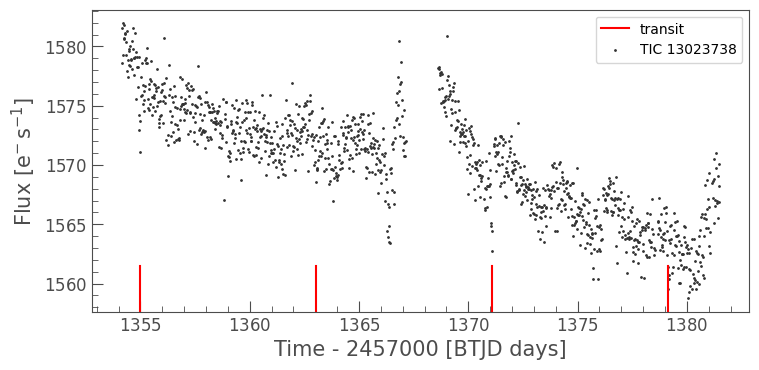

In [8]:
ax = tpf.to_lightcurve().remove_outliers(sigma=7).scatter();
ax.axvline(t0, c='red', ymax=0.15, label="transit");
ax.legend();
for i in [-1, 1, 2]: 
    ax.axvline(t0 + period * i, c='red', ymax=0.15, label="transit");

In [ ]:
# tpf = tpf_um[(2610 <= tpf_um.time.value)  & (tpf_um.time.value <= 2621.5)]
# ax = tpf.to_lightcurve().remove_outliers(sigma=7).scatter();

{'figs': [<Figure size 288x288 with 1 Axes>],
 'pvalues': [(0.2774133293667105,)],
 'centroid_offset_detected': [array([False])]}

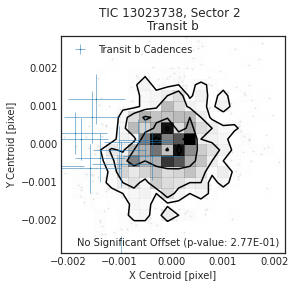

In [9]:
# if p-value is < 0.05 (5%), it means signficant centroid offset
# - distribution of centroid outside dips are not from the same population of the centroid during dips
# UNEXPECTED result: the test does not report signficant centroid shift, even though it is an NEB per ExoFOP
# (also indicative in per-pixel plot)
r = centroid_test(tpf, period, t0, duration, aperture_mask='pipeline', plot=True);
r

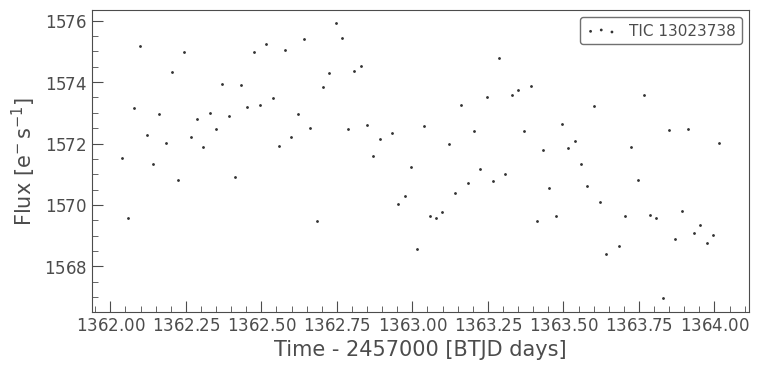

In [12]:
transit_idx = 0
tpf_trunc = tpf[(t0 + period * transit_idx - 1 <= tpf.time.value) & (tpf.time.value <= t0 + period * transit_idx + 1)]
tpf_trunc.to_lightcurve().remove_outliers(sigma=7).scatter();

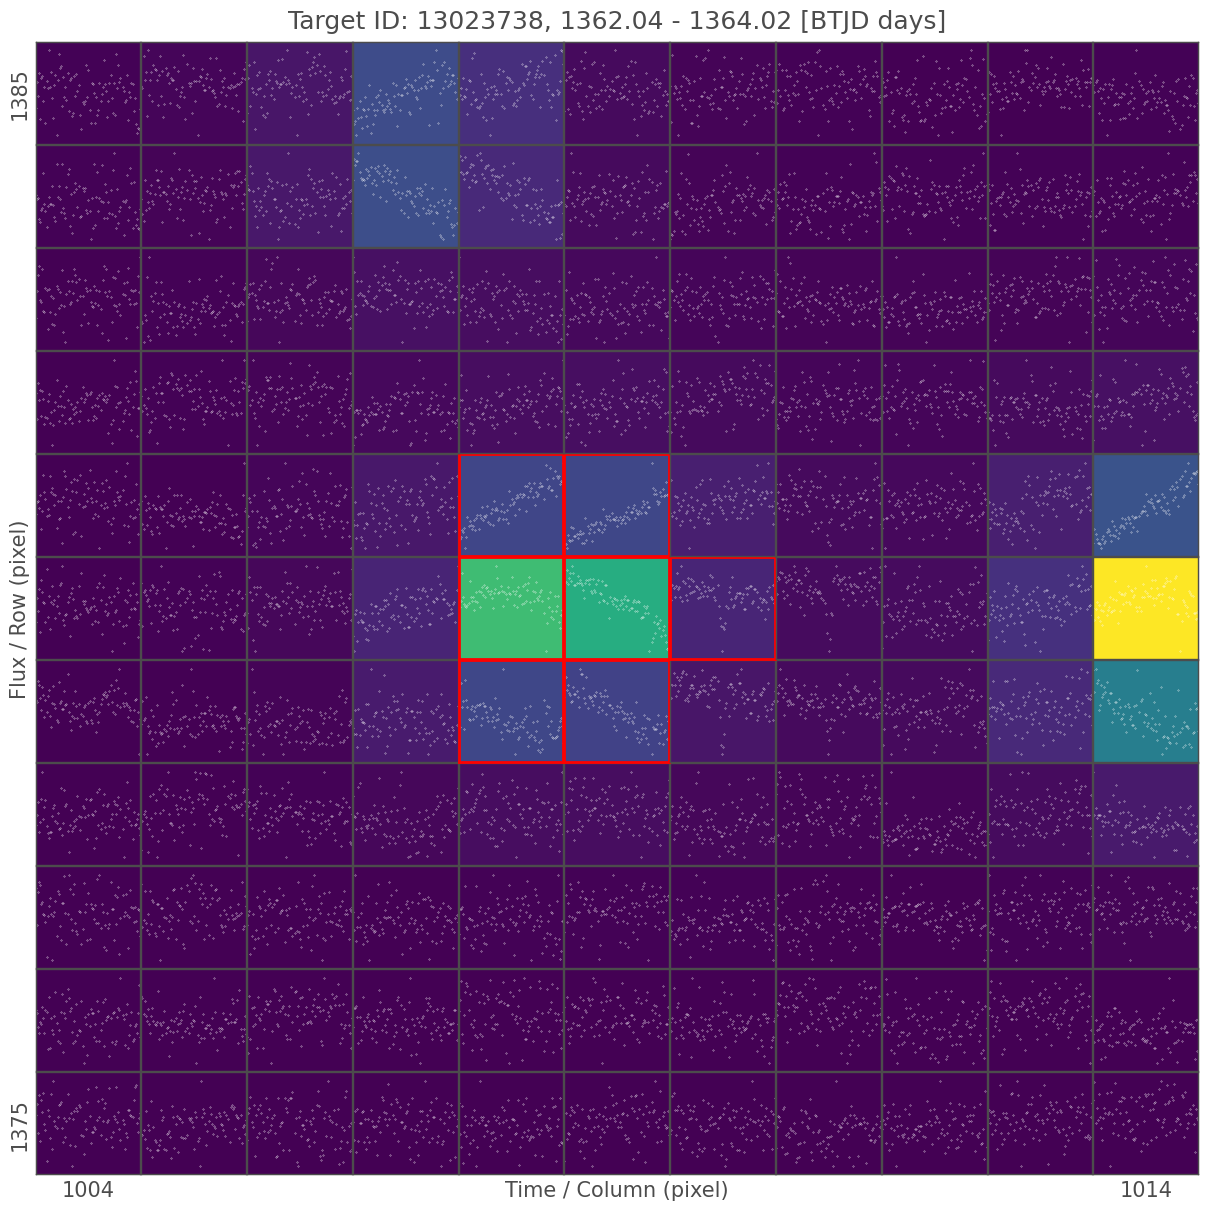

In [13]:
ax = tpf_trunc.plot_pixels(aperture_mask="pipeline", show_flux=True);